# True Reach Estimator
We are looking to build an estimator around instagram users true reach and impressions. This data is accessible through the business api but in Q1 2018 Instagram blocked influencer marketing teams from this endpoint. We are able to collect a sample of this data to see if there working correlations between currently public data and true reach/impressions.

Data: the CSV we have contains one year worth of data from 5,000 influencer level Instagram users.

# The goal:
Given the public data points create an accurate estimate of each posts reach and impressions. The ideal would be as accurate as possible, but a 10% range will work for the business.

## Trial 2 - Logarithmic Transformation and Scaling

After an initial trial of exploring the data and cleaning it up. We decided to do a log transformation and scale the data.

Process:
- Import the data
- Split the data into a test and training set
- Observe the data once again before doing a transformation
- Log transform the training set
- Scale the data after the log transformation
- Set conditions on the training data to eliminate outliers
- Create a regression model on our variables to determine the effectiveness of the data so far 
- Use the regression model to check for accuracy in the prediction across the dataset
- Summarize our findings and suggest next steps if unsucessful

# Get the data into the notebook

In [1]:
# import necessary libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
import requests
import re
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn')

In [2]:
# import the data file
df = pd.read_csv('trial_1_2.csv')
df.head()

,Unnamed: 0,followers,published,likes,comments,impressions,reach
0,0,68172,2018-06-18T01:26:44.000+00:00,107,1,2301,1782
1,1,68172,2018-06-17T18:47:24.000+00:00,323,1,9563,8131
2,2,68223,2018-06-19T02:24:03.000+00:00,38,1,290,261
3,3,68223,2018-06-18T16:44:25.000+00:00,656,12,11360,9082
4,4,67812,2018-05-30T03:22:11.000+00:00,2044,26,100970,85215


In [3]:
# drop the first column which are just the indices and the columns we will not use in for the training
df.drop(columns=['Unnamed: 0', "published", "impressions"], inplace=True)
df.head()
len(df)

728018

# Split the data into training and testing sets

In [4]:
from sklearn.model_selection import train_test_split
df, test = train_test_split(df, test_size=0.2)

# Visualize the data once more

Take a look at the scatter plots of the likes, comments, and followers against the reach

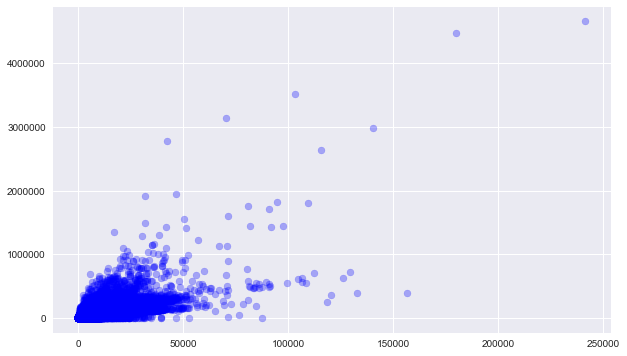

In [5]:
plt.figure(figsize=(10,6))
plt.scatter(df.likes, df.reach,  color='blue', alpha = 0.3)
plt.show()

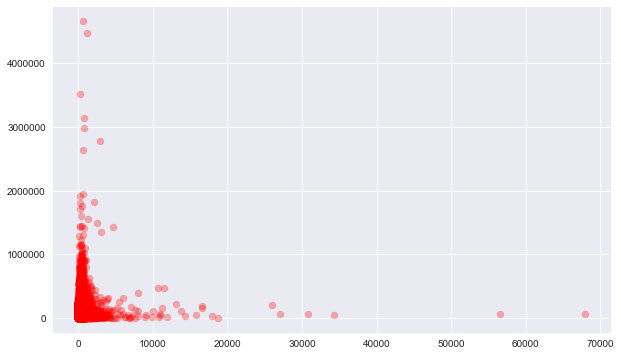

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(df.comments, df.reach,  color='red', alpha = 0.3)
plt.show()

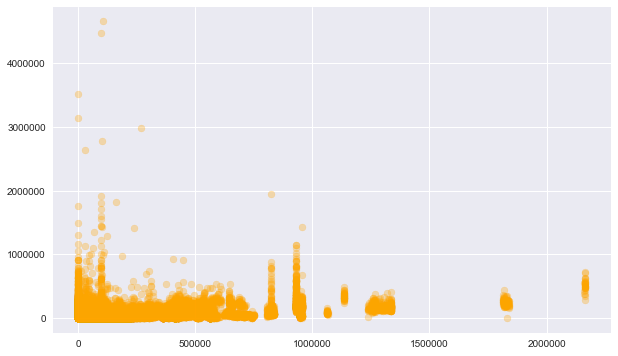

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(x=df.followers, y=df.reach,  color='orange', alpha = 0.3)
plt.show()

## A few observations
- We seem to have a semi linear relationship between likes and reach, but heteroscedastic
- We seem to have a curvilinear relationship between comments and reach 
- We seem to have some weird things happening with followers and reach.

# Looking at the histograms prior to transformation

We take a look at the histograms of the independent variables we are interested in to determine which should be transformed to have a more normal distribution. We will log the features to see how it affects the distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c21aeffd0>,
      dtype=object)

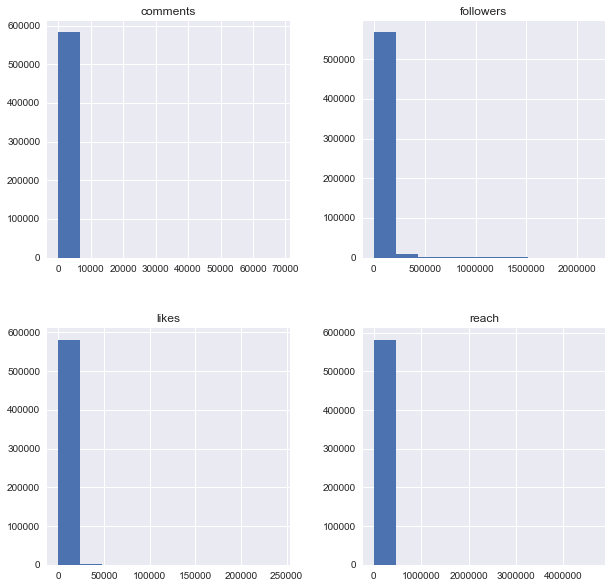

In [8]:
df.hist(figsize=[10,10])

It seems like it the data can benefit from a log transform.

# Clean data

We need to get rid of zero likes, comments, and followers in order to avoid divide by zero errors when transforming and scaling.

In [9]:
# drop anyone that has no reach
df = df.loc[(df['reach']>=1)]
print(df.head())
len(df)

        followers  likes  comments  reach
434030        447     40         3     68
504008          0   1314        23   4775
394867       2519     28         1    292
890         40064    856         4  11296
356445      36677   3871       221  27705


582346

We just cut 85 post from our data, which is less than 1% of our original data. Let's continue cutting out some of the things we know are weird like having 0 likes yet having a reach or having 0 followers and having a reach.

In [10]:
df = df[(df['likes']>=1)]
df = df[(df['followers']>=1)]
print(df.head())
len(df)

        followers  likes  comments  reach
434030        447     40         3     68
394867       2519     28         1    292
890         40064    856         4  11296
356445      36677   3871       221  27705
193220       3106    224        30   1193


431431

We just cut 189165 posts from our data, so we have just cut about 25% of our original data, worth of bad data. Let's see how cutting comments less than 1 affects the data.

In [11]:
df = df[(df['comments']>=1)]
print(df.head())
len(df)

        followers  likes  comments  reach
434030        447     40         3     68
394867       2519     28         1    292
890         40064    856         4  11296
356445      36677   3871       221  27705
193220       3106    224        30   1193


417496

# Transforming the Likes, Comments, and Followers

Create a new dataframe with the logarithmic transformation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c226a5978>,
      dtype=object)

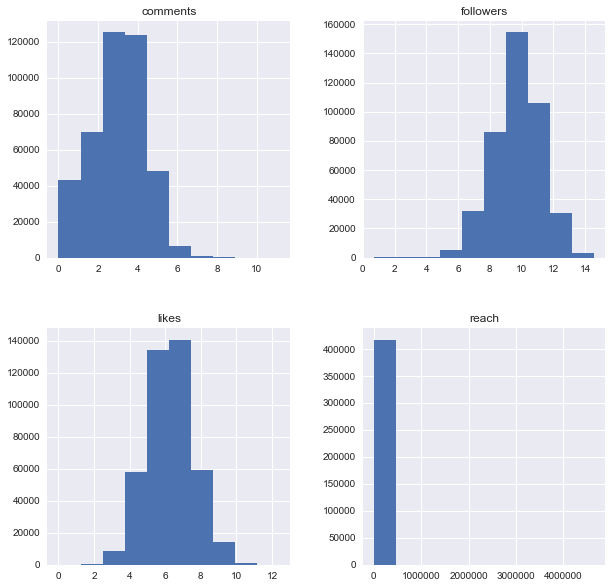

In [12]:
import numpy as np
data_log = pd.DataFrame([])
data_log["followers"] = np.log(df["followers"])
data_log["comments"] = np.log(df["comments"])
data_log["likes"] = np.log(df["likes"])
data_log["reach"] = df["reach"]
data_log.hist(figsize=[10,10])

## A few observations
- Logging the features seem to have normalize the distribution of the features a bit.
- Likes seem to benefit the most from the transformation being more normal, while comments skewed to the right, and followers are skewed to the left.

We scaled the the logarithmic transformation and plot the histograms to see if that makes a difference.

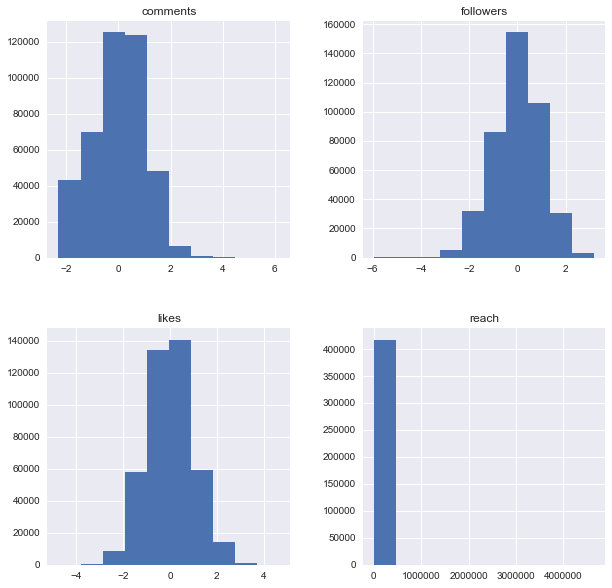

In [13]:
# # Standardization
scaled_fol = (data_log["followers"]-np.mean(data_log["followers"]))/np.sqrt(np.var(data_log["followers"]))
# # Standardization
scaled_com = (data_log["comments"]-np.mean(data_log["comments"]))/np.sqrt(np.var(data_log["comments"]))
# # Standardization
scaled_like = (data_log["likes"]-np.mean(data_log["likes"]))/np.sqrt(np.var(data_log["likes"]))
# scaled_reach = (data_log["reach"]-np.mean(data_log["reach"]))/np.sqrt(np.var(data_log["reach"]))


data_scaled = pd.DataFrame([])
data_scaled["followers"] = scaled_fol
data_scaled["comments"] = scaled_com
data_scaled["likes"] = scaled_like
data_scaled["reach"] = df.reach.copy()

data_scaled.hist(figsize  = [10, 10]);

In [14]:
data_scaled.head()

,followers,comments,likes,reach
434030,-2.390281,-1.466000,-1.959099,68
394867,-1.253675,-2.301335,-2.230246,292
890,0.564974,-1.247260,0.369712,11296
356445,0.506911,1.803181,1.516862,27705
193220,-1.115977,0.284780,-0.649440,1193


The histograms are look the same but the scales are just different. Since we are doing a linear regression, we do not need to scale.

# Creating our models

First lets take a look at the ols summary of the log transform

In [15]:
# take a stab at the ols model with the data that was log tansform
lr_model = ols(formula='reach~followers + likes + comments', data=data_log).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                 3.721e+04
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        13:47:20   Log-Likelihood:            -4.8621e+06
No. Observations:              417496   AIC:                         9.724e+06
Df Residuals:                  417492   BIC:                         9.724e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.342e+04    279.337   -227.042      0.000    -6.4e+04   -6.29e+04
followers   1192.1913     45.363     26.281      0.000    1103.281    1281.101
likes        1.03e+04     63.781    161.516      0.000    1.02e+04    1.04e+04
comments    -831.4131     45.297    -18.355      0.000    -920.194    -742.633
==============================================================================
Omnibus:                  1233637.921   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     364296069627.770
Skew:                          41.501   Prob(JB):                         0.00
Kurtosis:                    4578.465   Cond. No.                         80.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Using the coefficients from the summary above we defined a test function that takes in unscaled inputs and scales them before running it through the function.

In [16]:
def reach_test_log(followers, likes, comments): 
    return (1282.759*np.log(followers)) + (1.013e+04*np.log(likes)) + (-783.3645*np.log(comments)) -6.341e04

But we can just use the ols built in predict function/method the run the data through 

In [17]:
# create a column  for the test reach and the reach difference
data_log["test_reach"] = lr_model.predict(data_log)
data_log["reach_diff"] = data_log.reach - data_log.test_reach

In [18]:
data_log.head()

,followers,comments,likes,reach,test_reach,reach_diff
434030,6.102559,1.098612,3.688879,68,-19057.551961,19125.551961
394867,7.831617,0.000000,3.332205,292,-19757.147219,20049.147219
890,10.598233,1.386294,6.752270,11296,17621.158274,-6325.158274
356445,10.509905,5.398163,8.261268,27705,29725.603216,-2020.603216
193220,8.041091,3.401197,5.411646,1193,-913.394774,2106.394774


### Observe the RSME of the log transforms

In [19]:
# rsme of the training data
mean_squared_error(data_log.test_reach, data_log.reach)**.5

27634.152951963537

In [20]:
# rsme of the test data
test_reach = lr_model.predict(test)
mean_squared_error(test_reach, test.reach)**.5

131920710.41174623

Next lets take a look at the ols summary of the scaled data

In [21]:
# take a look at the summary
lr_model_2 = ols(formula='reach~followers + likes + comments', data=data_scaled).fit()
lr_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                 3.721e+04
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        13:47:21   Log-Likelihood:            -4.8621e+06
No. Observations:              417496   AIC:                         9.724e+06
Df Residuals:                  417492   BIC:                         9.724e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.022e+04     42.768    239.024      0.000    1.01e+04    1.03e+04
followers   1813.6184     69.008     26.281      0.000    1678.364    1948.873
likes       1.355e+04     83.900    161.516      0.000    1.34e+04    1.37e+04
comments   -1093.4551     59.573    -18.355      0.000   -1210.217    -976.693
==============================================================================
Omnibus:                  1233637.921   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     364296069627.770
Skew:                          41.501   Prob(JB):                         0.00
Kurtosis:                    4578.465   Cond. No.                         3.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# create a new column in the data frame that has the reach for the test  
data_scaled["test_reach"] = lr_model_2.predict(data_scaled)

### Observe the RSME of the scaled data

In [23]:
mean_squared_error(data_scaled.test_reach, data_scaled.reach)**.5

27634.152951963537

In [24]:
scaled_test = lr_model_2.predict(test)
mean_squared_error(scaled_test, test.reach)**.5

195877618.76113823

In [25]:
data_scaled.head(5)

,followers,comments,likes,reach,test_reach
434030,-2.390281,-1.466000,-1.959099,68,-19057.551961
394867,-1.253675,-2.301335,-2.230246,292,-19757.147219
890,0.564974,-1.247260,0.369712,11296,17621.158274
356445,0.506911,1.803181,1.516862,27705,29725.603216
193220,-1.115977,0.284780,-0.649440,1193,-913.394774


In [26]:
test.head()

,followers,likes,comments,reach
104897,140047,4537,96,58748
566609,10866,163,13,1209
259613,0,1628,118,9690
453622,16898,854,9,1155
494111,0,2261,30,11884


In [27]:
test['test_reach'] = round(lr_model.predict(test),1)
test['reach_diff'] = round(test['reach'] - test['test_reach'],1)

# Summary

Even after doing a log transform the $R^2$ was just above .21 and the RMSE was over 27,000 on our training data. For our test data, the RMSE was over 100,000(log transform) on the first model with our test dataset and over 200,000 on our second model(log transform and scaled). With such large RMSE we decided not to do an accuracy histogram. 

We conclude that we must do some further analysis on the data. In our next trial, we will see the effects of a curvilinear regression.